# PARAMETERS
**BEFORE YOU START**
* **Kaggle dataset GCS path** from [here](https://www.kaggle.com/nadimsarwar/dataset/edit/run/53975496)
* **UPLOAD DATA CONFIG**

**SET THE FOLLOWING VARIABLES**
```python
  GCS_PATH    :    The raw path of kaggle gcs 
  EPOCHS      :    number of epochs  
  BUFFER_SIZE :    shuffle size of the buffer    
  MODEL_NAME  :    name of the saved model
  TF_IDEN     :    name of the zipped folder
  DATA_FOLDER :    tfrecords folder
``` 

In [1]:
GCS_PATH    =    "gs://kds-3e49f7183812d5c81512e7fb2f023181dc9485bec5bd3305f36356a5"# @param 
MODEL_NAME  =    "densenet121_leaf"# @param
DATA_FOLDER =    "tfrecords"# @param
EPOCHS      =    250   #@param {type:"slider", min:10, max:500, step:10}  
BUFFER_SIZE =    2048  # @param {type:"slider", min:128, max:2048, step:128}   
WEIGHT_PATH =    f'{MODEL_NAME}.h5' 

GCS_PATH    =    f'{GCS_PATH}/{DATA_FOLDER}'
print(GCS_PATH)
print(WEIGHT_PATH)



gs://kds-3e49f7183812d5c81512e7fb2f023181dc9485bec5bd3305f36356a5/tfrecords
densenet121_leaf.h5


# Config Reading

In [2]:
import json

with open('config.json') as f:
  config = json.load(f)

IMAGE_TYPE =  config['image_type']
IMG_DIM    =  config['img_dim']
LABELS     =  config['labels']
NB_CHANNEL =  config['nb_channels']
NB_CLASSES =  config['nb_classes']
NB_TRAIN   =  config['nb_test_data']
NB_TEST    =  config['nb_train_data']


# DEFAULT OPS: TPU TFrecords

## TPU initialize

In [3]:
import tensorflow as tf 
import os 


print(tf.__version__)
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

2.4.1
Running on TPU  grpc://10.12.234.146:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.12.234.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.12.234.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


## Training Params

In [4]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
TOTAL_DATA =  NB_TRAIN+NB_TEST 
STEPS_PER_EPOCH = TOTAL_DATA//BATCH_SIZE
EVAL_STEPS      = NB_TEST//BATCH_SIZE

## Data input function

In [5]:
def data_input_fn(mode): 
    '''
      This Function generates data from gcs
    '''
    
    def _parser(example):
        feature ={  'image'  : tf.io.FixedLenFeature((),tf.string) ,
                    'label'  : tf.io.FixedLenFeature((),tf.int64)
        }    
        parsed_example=tf.io.parse_single_example(example,feature)
        image_raw=parsed_example['image']
        image=tf.image.decode_png(image_raw,channels=NB_CHANNEL)
        image=tf.cast(image,tf.float32)/255.0
        image=tf.reshape(image,(IMG_DIM,IMG_DIM,NB_CHANNEL))
        
        idx = tf.cast(parsed_example['label'], tf.int32)
        label=tf.one_hot(idx,NB_CLASSES,dtype=tf.float32)
        return image,label

    gcs_pattern=os.path.join(GCS_PATH,mode,'*.tfrecord')
    file_paths = tf.io.gfile.glob(gcs_pattern)
    dataset = tf.data.TFRecordDataset(file_paths)
    dataset = dataset.map(_parser)
    dataset = dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


# Data Check

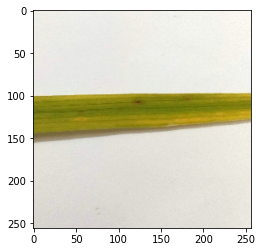

Image Batch Shape: (128, 256, 256, 3)
Target Batch Shape: (128, 4)
tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_ds  =   data_input_fn("train")
test_ds   =   data_input_fn("test")


for x,y in train_ds.take(1):
    data=np.squeeze(x[0])
    plt.imshow(data)
    plt.show()
    print('Image Batch Shape:',x.shape)
    print('Target Batch Shape:',y.shape)
    print(y[0])

# MODEL definition
**THIS IS CHANGEABLE**

In [7]:
from tensorflow.keras.applications import DenseNet121
with strategy.scope():
    rnet = DenseNet121(
        input_shape=(IMG_DIM,IMG_DIM,NB_CHANNEL),
        weights="imagenet",
        include_top=False
    )
    # trainable rnet
    rnet.trainable = True
    model = tf.keras.Sequential([
        rnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NB_CLASSES, activation='softmax',dtype='float32')
    ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )

model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


## Callbacks
**CHANGABLE**

In [8]:

# reduces learning rate on plateau
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                  cooldown= 10,
                                                  patience=10,
                                                  verbose =1,
                                                  min_lr=0.1e-5)

mode_autosave = tf.keras.callbacks.ModelCheckpoint(WEIGHT_PATH,
                                                  monitor='val_categorical_accuracy', 
                                                  mode = 'max', 
                                                  save_best_only=True, 
                                                  verbose=1, 
                                                  period =1)

# stop learining as metric on validatopn stop increasing
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, 
                                                  verbose=1, 
                                                  mode = 'auto') 

callbacks = [mode_autosave, lr_reducer,early_stopping ]


# MODELING

## Model training

In [9]:
history = model.fit(train_ds,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    verbose=1, 
                    validation_data=test_ds,
                    validation_steps=EVAL_STEPS,
                    callbacks=callbacks)

Epoch 1/250
16/16 [==============================] - 92s 1s/step - loss: 1.4504 - categorical_accuracy: 0.4184 - val_loss: 6.7337 - val_categorical_accuracy: 0.2832

Epoch 00001: val_categorical_accuracy improved from -inf to 0.28320, saving model to densenet121_leaf.h5
Epoch 2/250
16/16 [==============================] - 12s 808ms/step - loss: 0.8715 - categorical_accuracy: 0.6333 - val_loss: 27.1534 - val_categorical_accuracy: 0.2500

Epoch 00002: val_categorical_accuracy did not improve from 0.28320
Epoch 3/250
16/16 [==============================] - 11s 747ms/step - loss: 0.6815 - categorical_accuracy: 0.7374 - val_loss: 4.1463 - val_categorical_accuracy: 0.4076

Epoch 00003: val_categorical_accuracy improved from 0.28320 to 0.40755, saving model to densenet121_leaf.h5
Epoch 4/250
16/16 [==============================] - 11s 738ms/step - loss: 0.5761 - categorical_accuracy: 0.7778 - val_loss: 3.2997 - val_categorical_accuracy: 0.4154

Epoch 00004: val_categorical_accuracy improved

## Model history

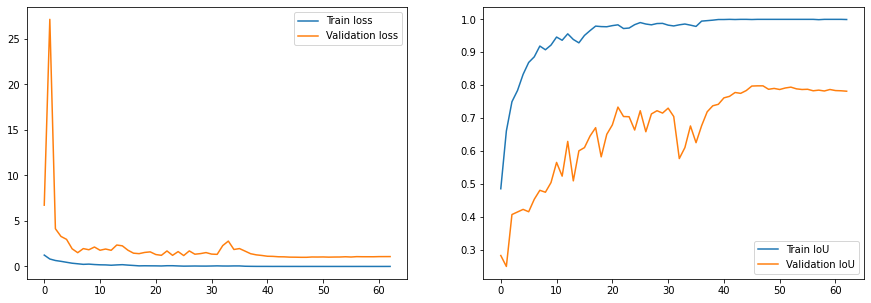

In [10]:
def plot_history(history):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["categorical_accuracy"], label="Train IoU")
    ax_acc.plot(history.epoch, history.history["val_categorical_accuracy"], label="Validation IoU")
    ax_acc.legend()
    plt.show()

    # show history
plot_history(history)

# Predictions
**Helpers**
* USE binary functions only with binary images

In [ ]:
import cv2
from glob import glob 
def stripPads(arr,val):
    '''
        strip specific values
    '''
    arr=arr[~np.all(arr == val, axis=1)]
    arr=arr[:, ~np.all(arr == val, axis=0)]
    return arr
def binary_thresh(img):
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img,(5,5),0)
    _,img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return img  

def binary_inversion(img):
    img = img/255
    img = 1 - img
    return img

def binary_revert(img):
    img = 1 -img
    img = img*255
    img=img.astype('uint8')
    return img
    

  




**THIS FUNCTION WILL CHANGE ON BINARY DATA**

In [ ]:
def binary_check(img):
  img = cv2.dilate(img,(3,3),
                   iterations = 10) 
  return img

## Prediction Data processing
* Create a folder called **data** and upload all the images there
* For using TPU the number of data has to be > = 8

In [ ]:
data=[]
for img_path in glob(os.path.join(os.getcwd(),'data','*.*')):
  # read image
  if IMAGE_TYPE=='rgb':
    img=cv2.imread(img_path)
  else:
    img=cv2.imread(img_path,0)
  # check binary ops
  if IMAGE_TYPE=='binary':
    img=binary_thresh(img)
    img=stripPads(img,255)
    img=cv2.resize(img,(IMG_DIM,IMG_DIM))
    img=binary_thresh(img)
    img=binary_inversion(img)
    img=binary_check(img)
    img=binary_revert(img)
    
  else:
    img=cv2.resize(img,(IMG_DIM,IMG_DIM))
    
  img=np.expand_dims(img,axis=-1)
  if IMAGE_TYPE!='rgb':
    img=np.expand_dims(img,axis=0)
  
  data.append(img)

if len(data)<8:
  # fill the rest with first data
  for i in range(8-len(data)):
    data.append(data[0])
# stack
data=np.vstack(data)
# normalize and float conversion
data=data/255.0
data.shape



## Display Predictions

In [ ]:
preds=model.predict(data)
for pred,img in zip(preds,data):
  img=img*255
  img=img.astype('uint8')
  plt.imshow(np.squeeze(img))
  plt.show()
  print(LABELS[np.argmax(pred)])
